<a href="https://colab.research.google.com/github/nopynospy/apu_deep_learning/blob/main/LAB9_DCGAN_octopus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This exercise trains the GAN network with octopus images from Google Quickdraw and generates synthetic octopus images**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


https://quickdraw.withgoogle.com/data/octopus

To download data: 
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/octopus.npy


Or, you may use this link: https://drive.google.com/file/d/1rnPf_2boiygqbwumc3KNlWt5zZKibgRU/view?usp=sharing


In [2]:
# This code runs Keras with tensorflow running in the background

import numpy as np
import pandas as pd
import os
from tensorflow import keras
from keras.models import Model, Sequential
from keras.layers import Input, Activation, Conv2D, AveragePooling2D, Reshape, Dense, BatchNormalization, Dropout, Flatten, UpSampling2D, Conv2DTranspose
from tensorflow.keras.optimizers import RMSprop
from keras.initializers import TruncatedNormal


from matplotlib import pyplot as plt
%matplotlib inline


In [3]:
input_images = "/content/drive/MyDrive/gan/octopus.npy"

In [4]:
data = np.load(input_images)

In [5]:
data.shape

(150152, 784)

In [6]:
data.shape[0]

150152

In [7]:
data = data/255
data = np.reshape(data,(data.shape[0],28,28,1))
img_w,img_h = data.shape[1:3]
data.shape

(150152, 28, 28, 1)

93215


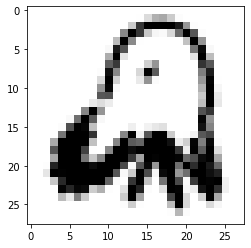

In [8]:
n = np.random.randint(data.shape[0]) # randomly select an image
print(n)
sample_image = data[n]
plt.imshow(sample_image[:,:,0], cmap='Greys')

Discriminator


In [9]:
def discriminator_builder(depth=64,p=0.4): # depth - number of filters, p - coeff for dropout
    
    # Define inputs
    inputs = Input((img_w,img_h,1))
    
    # Convolutional layers
    conv1 = Conv2D(depth*1, 5, strides=2, padding='same', activation='relu')(inputs)
    conv1 = Dropout(p)(conv1)
    
    conv2 = Conv2D(depth*2, 5, strides=2, padding='same', activation='relu')(conv1)
    conv2 = Dropout(p)(conv2)
    
    conv3 = Conv2D(depth*4, 5, strides=2, padding='same', activation='relu')(conv2)
    conv3 = Dropout(p)(conv3)
    
    conv4 = Conv2D(depth*8, 5, strides=1, padding='same', activation='relu')(conv3)
    conv4 = Flatten()(Dropout(p)(conv4))
    
    output = Dense(1, activation='sigmoid')(conv4)
    
    model = Model(inputs=inputs, outputs=output)
    model.summary()
    
    return model

discriminator = discriminator_builder()

discriminator.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.0008, clipvalue=1.0, decay=6e-8), metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         819456    
                                                                 
 dropout_2 (Dropout)         (None, 4, 4, 256)         0     

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Generator

Build a Generator Model
Stack of BN-ReLU-Conv2DTranpose to generate fake images
Output activation is sigmoid Sigmoid converges easily. instead of tanh in [1].
Arguments:
inputs (Layer): Input layer of the generator
the z-vector)
image_size (tensor): Target size of one side
(assuming square image)
Return generator (Model): Generator Model

In [10]:
def generator_builder(z_dim=100,depth=64,p=0.4):
    
    # Define inputs
    inputs = Input((z_dim,))
    
    # First dense layer
    dense1 = Dense(7*7*64)(inputs)
    dense1 = BatchNormalization(axis=-1,momentum=0.9)(dense1)
    dense1 = Activation(activation='relu')(dense1)
    dense1 = Reshape((7,7,64))(dense1)
    dense1 = Dropout(p)(dense1)
    
    # Convolutional layers
    conv1 = UpSampling2D()(dense1)
    conv1 = Conv2DTranspose(int(depth/2), kernel_size=5, padding='same', activation=None,)(conv1)
    conv1 = BatchNormalization(axis=-1,momentum=0.9)(conv1)
    conv1 = Activation(activation='relu')(conv1)
    
    conv2 = UpSampling2D()(conv1)
    conv2 = Conv2DTranspose(int(depth/4), kernel_size=5, padding='same', activation=None,)(conv2)
    conv2 = BatchNormalization(axis=-1,momentum=0.9)(conv2)
    conv2 = Activation(activation='relu')(conv2)
    
    #conv3 = UpSampling2D()(conv2)
    conv3 = Conv2DTranspose(int(depth/8), kernel_size=5, padding='same', activation=None,)(conv2)
    conv3 = BatchNormalization(axis=-1,momentum=0.9)(conv3)
    conv3 = Activation(activation='relu')(conv3)

    # Define output layers
    output = Conv2D(1, kernel_size=5, padding='same', activation='sigmoid')(conv3)

    # Model definition    
    model = Model(inputs=inputs, outputs=output)
    model.summary()
   
    return model

generator = generator_builder()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_1 (Dense)             (None, 3136)              316736    
                                                                 
 batch_normalization (BatchN  (None, 3136)             12544     
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 3136)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 dropout_4 (Dropout)         (None, 7, 7, 64)          0         
                                                           

Connecting the Adversaries

In [11]:
def adversarial_builder(z_dim=100):
    
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.0004, clipvalue=1.0, decay=3e-8), metrics=['accuracy'])
    model.summary()
    return model
adversarial_model = adversarial_builder()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 28, 28, 1)         396961    
                                                                 
 model (Functional)          (None, 1)                 4311553   
                                                                 
Total params: 4,708,514
Trainable params: 4,702,130
Non-trainable params: 6,384
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Training

In [12]:
# This is to set layer by layer of a net to be trainable or untrainable
# apparently, it is necessary to it at individual layer level rather than the whole "net" level

def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

In [13]:
def train(epochs=2000,batch=128):
    d_loss = []
    a_loss = []
    running_d_loss = 0
    running_d_acc = 0
    running_a_loss = 0
    running_a_acc = 0

    for i in range(epochs):

        if i%100 == 0:
            print(i) # print epoch number
        # randomly pick real images from dataset
        # data.shape[0] - Number of rows in data
        real_imgs = np.reshape(data[np.random.choice(data.shape[0],batch,replace=False)],(batch,28,28,1))
        # generate fake images using uniform random noise
        fake_imgs = generator.predict(np.random.uniform(-1.0, 1.0, size=[batch, 100]))
        
        x = np.concatenate((real_imgs,fake_imgs))
        
        # label real and fake images
        y = np.ones([2*batch,1]) # generates y with 256 (2x batch size) elements with value 1
        y[batch:,:] = 0.  # converts the last 128(batch size) elements to 0.0
       
        make_trainable(discriminator, True) # First train the discriminator
        # "discriminator.train_on_batch" Runs a single gradient update on a single batch of data
        # Try typing the above in a new cell and teh function appears in a pop up
        # or hover mouse on this function in the line below to see the pop up 
        # "d_loss.append" is for creating the sequence of losses as epochs progress. This is for plotting purposes
        d_loss.append(discriminator.train_on_batch(x,y))
        running_d_loss += d_loss[-1][0]
        running_d_acc += d_loss[-1][1]

        make_trainable(discriminator, False)  # Stop training the discriminator
        # input to the adversarial model which is only geenrator now because discriminator not training
        noise = np.random.uniform(-1.0, 1.0, size=[batch, 100])  
        y = np.ones([batch,1])
        a_loss.append(adversarial_model.train_on_batch(noise,y))
        running_a_loss += a_loss[-1][0]
        running_a_acc += a_loss[-1][1]
        
        if (i+1)%500 == 0:
            print('Epoch #{}'.format(i+1))
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, running_d_loss/i, running_d_acc/i)
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, running_a_loss/i, running_a_acc/i)
            print(log_mesg)
            
            noise = np.random.uniform(-1.0, 1.0, size=[16, 100])
            gen_imgs = generator.predict(noise)
            
            plt.figure(figsize=(5,5))
            
            for k in range(gen_imgs.shape[0]):
                plt.subplot(4, 4, k+1)
                plt.imshow(gen_imgs[k, :, :, 0], cmap='gray')
                plt.axis('off')
            
            plt.tight_layout()
            plt.show()
            
            # plt.savefig('./images/run2_{}.png'.format(i+1))
    return a_loss, d_loss
        

In [14]:
# To understand the command
batch = 128
real_imgs = np.reshape(data[np.random.choice(data.shape[0],batch,replace=False)],(batch,28,28,1))
real_imgs.shape

(128, 28, 28, 1)

0
100
200
300
400
Epoch #500
499: [D loss: 0.500476, acc: 0.779543]  [A loss: 1.883220, acc: 0.182459]


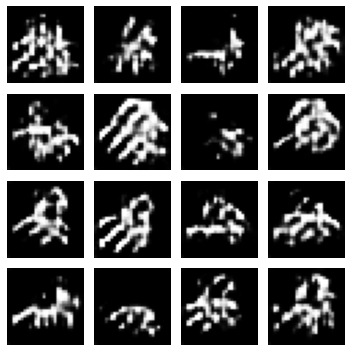

500
600
700
800
900
Epoch #1000
999: [D loss: 0.563508, acc: 0.716721]  [A loss: 1.498804, acc: 0.166534]


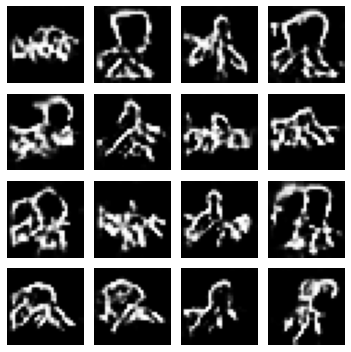

1000
1100
1200
1300
1400
Epoch #1500
1499: [D loss: 0.592833, acc: 0.689754]  [A loss: 1.345121, acc: 0.149652]


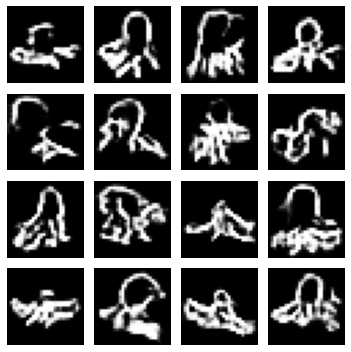

1500


KeyboardInterrupt: ignored

In [15]:
a_loss_complete, d_loss_complete = train(epochs=5000)

Evaluation

In [ ]:
ax = pd.DataFrame(
    {
        'Generative Loss': [loss[0] for loss in a_loss_complete],
        'Discriminative Loss': [loss[0] for loss in d_loss_complete],
    }
).plot(title='Training loss', logy=True)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

In [ ]:
ax = pd.DataFrame(
    {
        'Generative Loss': [loss[1] for loss in a_loss_complete],
        'Discriminative Loss': [loss[1] for loss in d_loss_complete],
    }
).plot(title='Training Accuracy')
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")

## Task 1: model visualization & saving

In [ ]:
from tensorflow.keras.utils import plot_model

In [ ]:
plot_model(generator,
           show_shapes=True)

In [ ]:
plot_model(discriminator,
           show_shapes=True)

In [ ]:
plot_model(adversarial_model,
           show_shapes=True)

In [ ]:
from google.colab import files

adversarial_model.save('lab9_adversarial.h5')
files.download('lab9_adversarial.h5')

## Task 2 Changing hyper parameter settings

# Tasks
1. Add model visualization, necessary callback, model saving etc.
2. Change hyper parameter settings and test performance
3. Include tensorboard to monitor the training
4. Extend the code to other images in google draw. 